# Explore candidates matched to stars

Thoughts of things we could do with stars for a section of the paper.

 * Plot a histogram of the light curve time span for candidates matched to stars. Is it bimodal? I.e., flares and variables?

 * How many potential stars have light curves that can be fit with a periodigram?

 * Explore the distributions of derived periods. What are most of these potential stars?

## Set up

Import packages and define plotting parameters.

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import astropy.units as u
from astropy.table import unique
from astropy.timeseries import LombScargle

In [2]:
all_filters = np.asarray(['g','r','i'], dtype='str')
all_fcolors = np.asarray(['green','red','blue'], dtype='str')
all_fshapes = np.asarray(['o','s','^'], dtype='str')
all_fsizes  = np.asarray([5, 5, 7], dtype='int')

Read in the nightly-epoch light curves and their measured parameters.

In [3]:
fnm = '../all_nightly_epochs_files/candidate_lightcurves.dat'
candLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_lef = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

In [4]:
fnm = '../all_nightly_epochs_files/candidate_lightcurve_parameters.dat'
paramLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
paramLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
paramLC_tspan = np.loadtxt(fnm, dtype='float', usecols=(2))
paramLC_tspan_g = np.loadtxt(fnm, dtype='float', usecols=(3))
paramLC_tspan_r = np.loadtxt(fnm, dtype='float', usecols=(4))
paramLC_tspan_i = np.loadtxt(fnm, dtype='float', usecols=(5))
paramLC_minmag = np.loadtxt(fnm, dtype='float', usecols=(6))
paramLC_minmag_g = np.loadtxt(fnm, dtype='float', usecols=(7))
paramLC_minmag_r = np.loadtxt(fnm, dtype='float', usecols=(8))
paramLC_minmag_i = np.loadtxt(fnm, dtype='float', usecols=(9))
paramLC_amp = np.loadtxt(fnm, dtype='float', usecols=(10))
paramLC_amp_g = np.loadtxt(fnm, dtype='float', usecols=(11))
paramLC_amp_r = np.loadtxt(fnm, dtype='float', usecols=(12))
paramLC_amp_i = np.loadtxt(fnm, dtype='float', usecols=(13))
paramLC_neps = np.loadtxt(fnm, dtype='int', usecols=(14))
paramLC_neps_g = np.loadtxt(fnm, dtype='int', usecols=(15))
paramLC_neps_r = np.loadtxt(fnm, dtype='int', usecols=(16))
paramLC_neps_i = np.loadtxt(fnm, dtype='int', usecols=(17))
del fnm

Read in all rows of the cross-matched file.

`flagstar` : 1 if matched to a star; 0 if matched to a galaxy; -1 if unmatched (int) 

`flagcore` : 1 if matched to the core of the galaxy; 0 otherwise (int) 

`flagmatch` : 1 if a star AND galaxy met constraints; 0 if one or the other; -1 if unmatched (int) 

In [5]:
fnm = '../cross_matched_LSDR10/candidate_xmatch_LSdr10.dat'
lsdr10xm_candid   = np.loadtxt(fnm, dtype='str', usecols=(0))
lsdr10xm_candra   = np.loadtxt(fnm, dtype='float', usecols=(1))
lsdr10xm_canddec  = np.loadtxt(fnm, dtype='float', usecols=(2))
lsdr10xm_flagstar = np.loadtxt(fnm, dtype='int', usecols=(4))
lsdr10xm_flagcore = np.loadtxt(fnm, dtype='int', usecols=(5))
lsdr10xm_flagmatch= np.loadtxt(fnm, dtype='int', usecols=(6))
lsdr10xm_sep      = np.loadtxt(fnm, dtype='float', usecols=(7))
lsdr10xm_ra       = np.loadtxt(fnm, dtype='float', usecols=(8))
lsdr10xm_dec      = np.loadtxt(fnm, dtype='float', usecols=(9))
lsdr10xm_rmag     = np.loadtxt(fnm, dtype='float', usecols=(13))
lsdr10xm_type     = np.loadtxt(fnm, dtype='str', usecols=(15))
lsdr10xm_shaper   = np.loadtxt(fnm, dtype='float', usecols=(19))
lsdr10xm_rpsfsize = np.loadtxt(fnm, dtype='float', usecols=(21))  
lsdr10xm_meanpz   = np.loadtxt(fnm, dtype='float', usecols=(23))
lsdr10xm_stdpz    = np.loadtxt(fnm, dtype='float', usecols=(24))
lsdr10xm_specz    = np.loadtxt(fnm, dtype='float', usecols=(25))
del fnm

Cross-match between the `lsdr10xm_` arrays and `paramLC_` arrays.

In [6]:
paramLC_xindex = np.zeros(len(paramLC_candid), dtype='int') - 1
lsdr10xm_pindex = np.zeros(len(lsdr10xm_candid), dtype='int') -1

for px in range(len(paramLC_candid)):
    tx = np.where(paramLC_candid[px] == lsdr10xm_candid)[0]
    if len(tx) == 1:
        paramLC_xindex[px] = tx[0]
        lsdr10xm_pindex[tx[0]] = px
    else:
        print(paramLC_candid[px], len(tx))
    del tx
del px

Reminder of how many candidates are matched to stars vs. galaxies.

In [7]:
sx = np.where(lsdr10xm_flagstar == 1)[0]
gx = np.where(lsdr10xm_flagstar == 0)[0]
print('Number of candidates matched to:')
print('stars: ', len(sx))
print('galaxies: ', len(gx))
del sx, gx

Number of candidates matched to:
stars:  6290
galaxies:  2587


## Illustrate the light curve parameters for candidates matched to stars

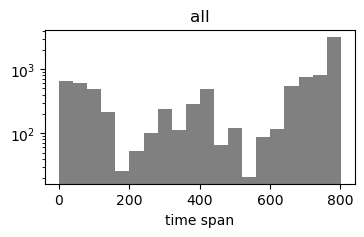

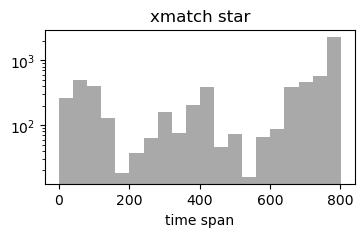

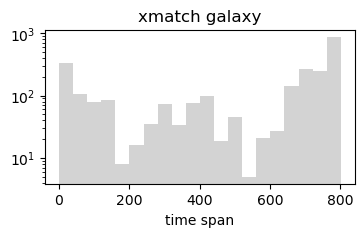

In [8]:
plt.figure(figsize=(4, 2))
plt.hist(paramLC_tspan, bins=20, log=True, color='grey')
plt.xlabel('time span')
plt.title('all')
plt.show

tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.hist(paramLC_tspan[px], bins=20, log=True, color='darkgrey')
plt.xlabel('time span')
plt.title('xmatch star')
plt.show()
del tx, px

tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.hist(paramLC_tspan[px], bins=20, log=True, color='lightgrey')
plt.xlabel('time span')
plt.title('xmatch galaxy')
plt.show()
del tx, px

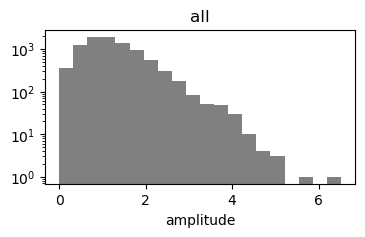

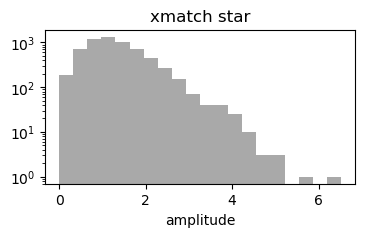

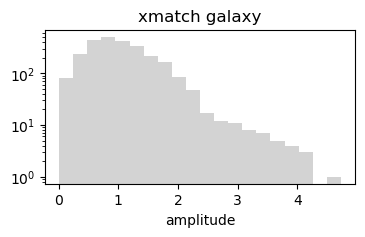

In [9]:
plt.figure(figsize=(4, 2))
plt.hist(paramLC_amp, bins=20, log=True, color='grey')
plt.xlabel('amplitude')
plt.title('all')
plt.show

tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.hist(paramLC_amp[px], bins=20, log=True, color='darkgrey')
plt.xlabel('amplitude')
plt.title('xmatch star')
plt.show()
del tx, px

tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.hist(paramLC_amp[px], bins=20, log=True, color='lightgrey')
plt.xlabel('amplitude')
plt.title('xmatch galaxy')
plt.show()
del tx, px

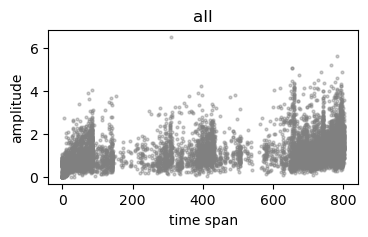

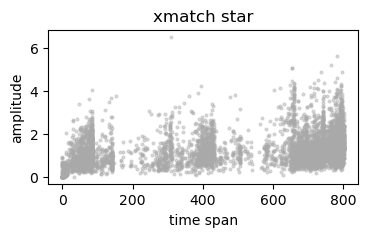

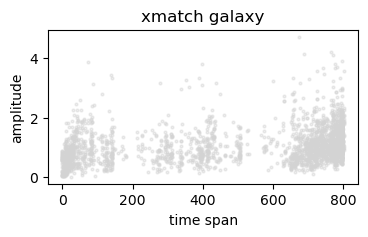

In [10]:
plt.figure(figsize=(4, 2))
plt.plot(paramLC_tspan, paramLC_amp, 'o', ms=2, alpha=0.4, color='grey')
plt.xlabel('time span')
plt.ylabel('amplitude')
plt.title('all')
plt.show

tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.plot(paramLC_tspan[px], paramLC_amp[px], 'o', ms=2, alpha=0.4, color='darkgrey')
plt.xlabel('time span')
plt.ylabel('amplitude')
plt.title('xmatch star')
plt.show()
del tx, px

tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.plot(paramLC_tspan[px], paramLC_amp[px], 'o', ms=2, alpha=0.4, color='lightgrey')
plt.xlabel('time span')
plt.ylabel('amplitude')
plt.title('xmatch galaxy')
plt.show()
del tx, px

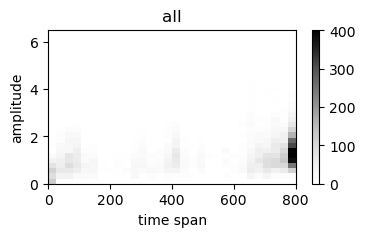

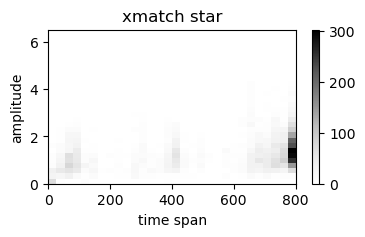

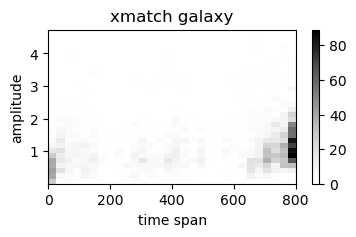

In [11]:
plt.figure(figsize=(4, 2))
plt.hist2d(paramLC_tspan, paramLC_amp, bins=30, cmap='Greys')
plt.colorbar()
plt.xlabel('time span')
plt.ylabel('amplitude')
plt.title('all')
plt.show

tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.hist2d(paramLC_tspan[px], paramLC_amp[px], bins=30, cmap='Greys')
plt.colorbar()
plt.xlabel('time span')
plt.ylabel('amplitude')
plt.title('xmatch star')
plt.show()
del tx, px

tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.hist2d(paramLC_tspan[px], paramLC_amp[px], bins=30, cmap='Greys')
plt.colorbar()
plt.xlabel('time span')
plt.ylabel('amplitude')
plt.title('xmatch galaxy')
plt.show()
del tx, px

## Try a periodogram for a random candidate

Choose one candidate randomly out of all those that are (1) matched to a star and (2) have a suitable light curve.

Attempt a periodogram with it.

In [12]:
tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]

ix = np.where((paramLC_tspan[px] > 40) & (paramLC_amp[px] > 1) & (paramLC_neps[px] > 30))[0]
print(len(ix), ' out of ', len(px), ' candidates meet the conditions.')

rx = np.random.choice(len(ix), 1)
x = px[ix[rx]]
print('randomly selected candidate: ', paramLC_candid[x])
cand = paramLC_candid[x]
del tx, px, ix, rx, x

1344  out of  6290  candidates meet the conditions.
randomly selected candidate:  ['DC21iof']


Index the parameters and light curve points that belong to this candidate.

In [13]:
px = np.where(paramLC_candid == cand)[0]
cx = np.where(candLC_candid == cand)[0]

Print some parameters for this candidate.

In [14]:
print(paramLC_field[px[0]], paramLC_candid[px[0]])
print(' ')
print('       %6s %6s %6s %6s ' % ('all', 'g', 'r', 'i'))
print('tspan  %6.1f %6.1f %6.1f %6.1f' % (paramLC_tspan[px[0]], paramLC_tspan_g[px[0]], paramLC_tspan_r[px[0]], paramLC_tspan_i[px[0]]))
print('minmag %6.1f %6.1f %6.1f %6.1f' % (paramLC_minmag[px[0]], paramLC_minmag_g[px[0]], paramLC_minmag_r[px[0]], paramLC_minmag_i[px[0]]))
print('amp    %6.1f %6.1f %6.1f %6.1f' % (paramLC_amp[px[0]], paramLC_amp_g[px[0]], paramLC_amp_r[px[0]], paramLC_amp_i[px[0]]))
print('neps   %6i %6i %6i %6i' % (paramLC_neps[px[0]], paramLC_neps_g[px[0]], paramLC_neps_r[px[0]], paramLC_neps_i[px[0]]))

COSMOS DC21iof
 
          all      g      r      i 
tspan   790.0  790.0  790.0    0.0
minmag   19.5   20.4   19.5    0.0
amp       1.9    1.1    1.8    0.0
neps       42     38     29      0


Choose the filter based on the above.

In [15]:
usefilt = 'r'

Show the light curve.

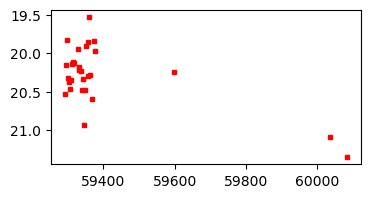

In [16]:
fx = np.where(candLC_filter[cx] == usefilt)[0]
days = candLC_mjd[cx[fx]]
mags = candLC_mag[cx[fx]]

x = np.where(all_filters == usefilt)[0]
sym = all_fshapes[x[0]]
clr = all_fcolors[x[0]]

plt.figure(figsize=(4, 2))
plt.plot(days, mags, sym, ms=3, color=clr)
plt.gca().invert_yaxis()
plt.show()

del x, sym, clr

For RR Lyrae and Cepheids, the periods are ~half a day to ~ten days, so try that range.

In [17]:
min_p = 0.1 * u.day
max_p = 20.0 * u.day
min_f = 1.0 / max_p
max_f = 1.0 / min_p

Do the Lomb Scargle periodogram fit.

In [18]:
frequency, power = LombScargle(days * u.day, mags).autopower(minimum_frequency=min_f, maximum_frequency=max_f)

In [19]:
print(np.min(power), np.max(power))
print(np.mean(power), np.std(power))
print((np.max(power)-np.mean(power))/np.std(power))

2.5692765406101192e-06 0.6165518784431168
0.07157769230311911 0.06570773970604643
8.293911624079943


Show the results.

Take as the best period the highest power peak.

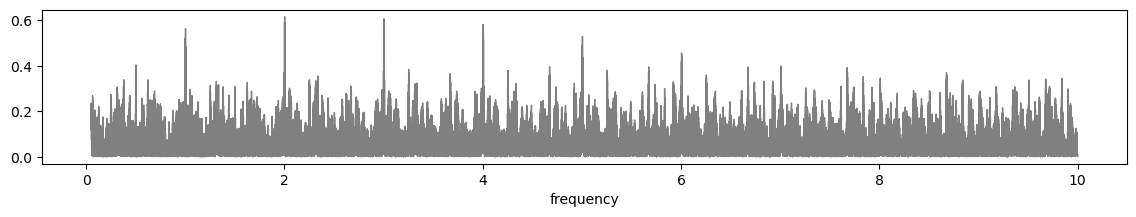

best period:  0.49950600477918305  in days


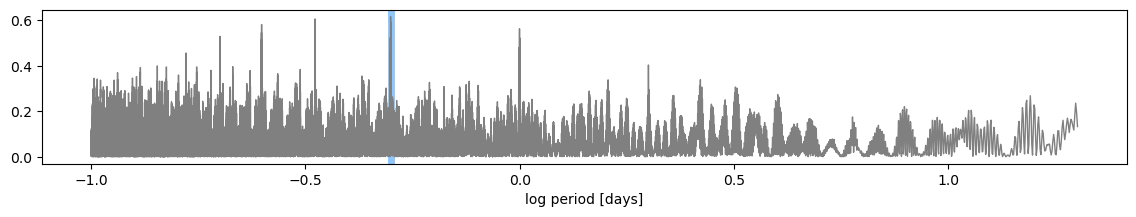

In [20]:
plt.figure(figsize=(14, 2))
plt.plot(frequency, power, color='grey', lw=1)
plt.xlabel('frequency')
plt.show()

tmp = np.argsort(power)
sx = tmp[::-1]
best_period = 1 / frequency[sx[0]].value
print('best period: ', best_period, ' in days')
del tmp, sx

plt.figure(figsize=(14, 2))
plt.axvline(np.log10(best_period), color='dodgerblue', lw=5, alpha=0.5)
plt.plot(np.log10(1 / frequency.value), power, color='grey', lw=1)
plt.xlabel('log period [days]')
plt.show()

Phase-fold the light curve and plot it.

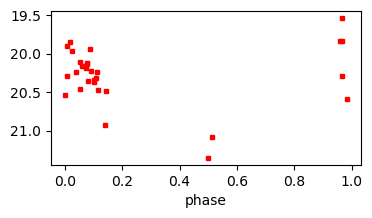

In [21]:
t0 = np.min(days)
days_norm = (days - t0) / best_period
phase = np.mod(days_norm, 1.0)
del t0

x = np.where(all_filters == usefilt)[0]
sym = all_fshapes[x[0]]
clr = all_fcolors[x[0]]

plt.figure(figsize=(4, 2))
plt.plot(phase, mags, sym, ms=3, color=clr)
plt.xlabel('phase')
plt.gca().invert_yaxis()
plt.show()

Alright that random one didn't really work out but let's try for more.

## Try periodograms for all

Do the periodogram for all candidates matched to stars, and for all filters for which sufficient data exists.

Then see if the periods match and have significant powers.

`Pbest` will be the best period.

`Ppwr` will be the power in that period.

`Psnr` with be the 'signal-to-noise ratio' for the best period: (max(power)-mean(power)) / std(power)

In [22]:
paramLC_Pbest_g = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Pbest_r = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Pbest_i = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Psnr_g = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Psnr_r = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Psnr_i = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Ppwr_g = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Ppwr_r = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Ppwr_i = np.zeros(len(paramLC_candid), dtype='float') - 1.0

Use the range that covers periods of RR Lyrae and Cepheids.

In [23]:
min_p = 0.1 * u.day
max_p = 20.0 * u.day
min_f = 1.0 / max_p
max_f = 1.0 / min_p

Make the periodograms for all candidates matched to stars that have sufficient time span, amplitude, and number of epochs.

In [24]:
t1 = time.time()

for p in range(len(paramLC_candid)):

    if (p == 10) | (p == 100) | (p == 1000):
        t2 = time.time()
        print('p=%6i, %5.1f seconds remain' % (p, ((t2-t1)/float(p))*(float(len(paramLC_candid)-p))))
    
    if (lsdr10xm_flagstar[paramLC_xindex[p]] == 1) & (paramLC_tspan[p] > 40) & (paramLC_amp[p] > 1) & (paramLC_neps[p] > 30):
        tmp1 = np.zeros(3, dtype='float')
        tmp2 = np.zeros(3, dtype='float')
        tmp3 = np.zeros(3, dtype='float')

        for f, filt in enumerate(all_filters):
            x = np.where((candLC_candid == paramLC_candid[p]) & 
                         (candLC_filter == filt))[0]

            if len(x) > 30:
                days = candLC_mjd[x]
                mags = candLC_mag[x]
                frequency, power = LombScargle(days * u.day, mags).autopower(minimum_frequency=min_f, maximum_frequency=max_f)
                mx = np.argmax(power)
                tmp1[f] = 1 / frequency[mx].value
                tmp2[f] = (np.max(power)-np.mean(power))/np.std(power)
                tmp3[f] = np.max(power)
                del days, mags, frequency, power, mx
            del x

        paramLC_Pbest_g[p] = tmp1[0]
        paramLC_Pbest_r[p] = tmp1[1]
        paramLC_Pbest_i[p] = tmp1[2]
        paramLC_Psnr_g[p] = tmp2[0]
        paramLC_Psnr_r[p] = tmp2[1]
        paramLC_Psnr_i[p] = tmp2[2]
        paramLC_Ppwr_g[p] = tmp3[0]
        paramLC_Ppwr_r[p] = tmp3[1]
        paramLC_Ppwr_i[p] = tmp3[2]
        del tmp1, tmp2
        
t2 = time.time()
print('elapsed: %5.1f' % (t2 - t1))
del t1, t2

p=    10,  74.4 seconds remain
p=   100,  21.5 seconds remain
p=  1000,  22.4 seconds remain
elapsed:  62.7


Explore the periodogram results by plotting them.

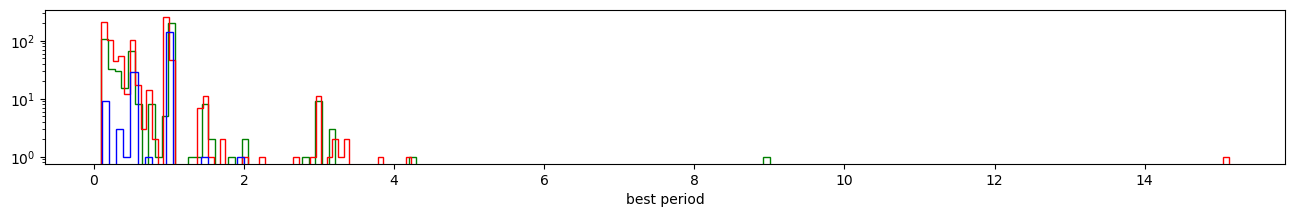

In [38]:
plt.figure(figsize=(16, 2))
gx = np.where(paramLC_Pbest_g > 0.0)[0]
rx = np.where(paramLC_Pbest_r > 0.0)[0]
ix = np.where(paramLC_Pbest_i > 0.0)[0]
plt.hist(paramLC_Pbest_g[gx], bins=100, histtype='step', log=True, color=all_fcolors[0])
plt.hist(paramLC_Pbest_r[rx], bins=200, histtype='step', log=True, color=all_fcolors[1])
plt.hist(paramLC_Pbest_i[ix], bins=20, histtype='step', log=True, color=all_fcolors[2])
del gx, rx, ix
plt.xlabel('best period')
plt.show()

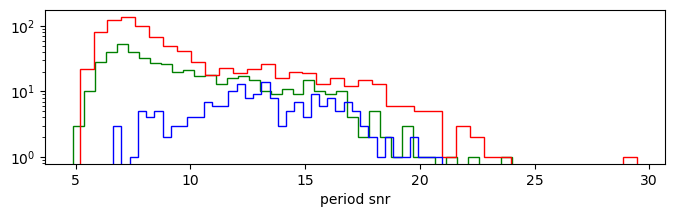

In [31]:
plt.figure(figsize=(8, 2))
gx = np.where(paramLC_Psnr_g > 0.0)[0]
rx = np.where(paramLC_Psnr_r > 0.0)[0]
ix = np.where(paramLC_Psnr_i > 0.0)[0]
plt.hist(paramLC_Psnr_g[gx], bins=40, histtype='step', log=True, color=all_fcolors[0])
plt.hist(paramLC_Psnr_r[rx], bins=40, histtype='step', log=True, color=all_fcolors[1])
plt.hist(paramLC_Psnr_i[ix], bins=40, histtype='step', log=True, color=all_fcolors[2])
del gx, rx, ix
plt.xlabel('period snr')
plt.show()

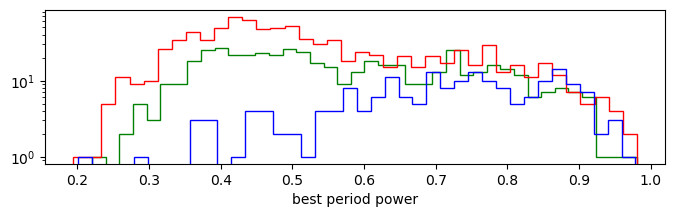

In [32]:
plt.figure(figsize=(8, 2))
gx = np.where(paramLC_Ppwr_g > 0.0)[0]
rx = np.where(paramLC_Ppwr_r > 0.0)[0]
ix = np.where(paramLC_Ppwr_i > 0.0)[0]
plt.hist(paramLC_Ppwr_g[gx], bins=40, histtype='step', log=True, color=all_fcolors[0])
plt.hist(paramLC_Ppwr_r[rx], bins=40, histtype='step', log=True, color=all_fcolors[1])
plt.hist(paramLC_Ppwr_i[ix], bins=40, histtype='step', log=True, color=all_fcolors[2])
del gx, rx, ix
plt.xlabel('best period power')
plt.show()

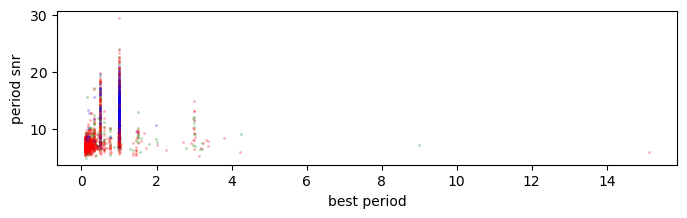

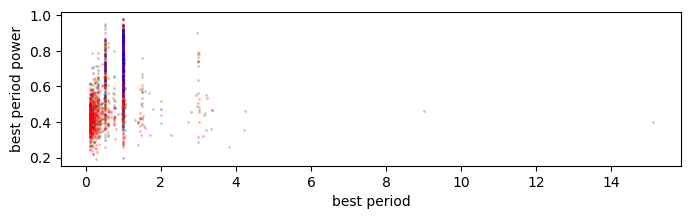

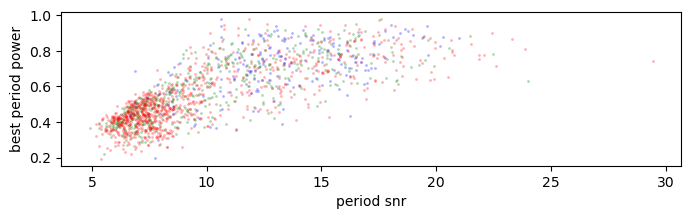

In [28]:
gx = np.where(paramLC_Pbest_g > 0.0)[0]
rx = np.where(paramLC_Pbest_r > 0.0)[0]
ix = np.where(paramLC_Pbest_i > 0.0)[0]

plt.figure(figsize=(8, 2))
plt.plot(paramLC_Pbest_g[gx], paramLC_Psnr_g[gx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[0])
plt.plot(paramLC_Pbest_r[rx], paramLC_Psnr_r[rx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[1])
plt.plot(paramLC_Pbest_i[ix], paramLC_Psnr_i[ix], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[2])
plt.xlabel('best period')
plt.ylabel('period snr')
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(paramLC_Pbest_g[gx], paramLC_Ppwr_g[gx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[0])
plt.plot(paramLC_Pbest_r[rx], paramLC_Ppwr_r[rx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[1])
plt.plot(paramLC_Pbest_i[ix], paramLC_Ppwr_i[ix], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[2])
plt.xlabel('best period')
plt.ylabel('best period power')
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(paramLC_Psnr_g[gx], paramLC_Ppwr_g[gx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[0])
plt.plot(paramLC_Psnr_r[rx], paramLC_Ppwr_r[rx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[1])
plt.plot(paramLC_Psnr_i[ix], paramLC_Ppwr_i[ix], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[2])
plt.xlabel('period snr')
plt.ylabel('best period power')
plt.show()

del gx, rx, ix

In [29]:
# x1 = np.where((paramLC_Pbest_r > 0.0) & (paramLC_Pbest_g > 0.0) & (paramLC_Psnr_r > 10.0) & (paramLC_Psnr_g > 10.0))[0]
# x2 = np.where((paramLC_Pbest_r > 0.0) & (paramLC_Pbest_i > 0.0) & (paramLC_Psnr_r > 10.0) & (paramLC_Psnr_i > 10.0))[0]

# plt.figure(figsize=(3, 3))
# # plt.plot([0, 3], [0, 3])
# # plt.plot(paramLC_Pbest_r[x1], paramLC_Pbest_g[x1], 'o', ms=4, alpha=0.3, mew=0, color='grey')
# plt.hist2d(paramLC_Pbest_r[x1], paramLC_Pbest_g[x1], bins=20, cmap='Greys')
# plt.xlabel('best period r')
# plt.ylabel('best period g')
# plt.xlim([-0.2, 3.2])
# plt.ylim([-0.2, 3.2])
# plt.show()

# plt.figure(figsize=(3, 3))
# # plt.plot([0, 3], [0, 3])
# # plt.plot(paramLC_Pbest_r[x2], paramLC_Pbest_i[x2], 'o', ms=4, alpha=0.3, mew=0, color='grey')
# plt.hist2d(paramLC_Pbest_r[x2], paramLC_Pbest_g[x2], bins=20, cmap='Greys')
# plt.xlabel('best period r')
# plt.ylabel('best period i')
# plt.xlim([-0.2, 3.2])
# plt.ylim([-0.2, 3.2])
# plt.show()

# del x1, x2

## Next steps

This is not super promising -- all the periods at ~1 day would be due to aliasing... But could take a look at results that were not exactly 1 day, and at a few of the candidates that had a very high SNR on the 1 day. 

But the bigger problem here is that these are difference-image magnitudes. We don't even know which objects are just saturated stars and returning basically random noise in the difference image...